# Analysis of optogenetic stimuli on top of drifting grating stimulus
- Variation of opto sub-target fractions ("opto_sub")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
# from helper_functions import load_sim_results, get_activity, plot_PSTH #, get_single_cell_psths, detect_rate_peaks
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [2]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/fb614119-68e3-4e9b-9214-7ee59c14fe42/analyses/simulations.pkl' # Param set 60, hex0_PV only, 0.0-1.0 subtarget fractions, 100% opto intensity

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/cc941ea0-ae57-4abd-afdd-64a7e6da954f/analyses/simulations.pkl' # Param set 60, hex0_PV only, 0.0-1.0 subtarget fractions, 25% opto intensity
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/3caff4ab-6dd6-4ee4-a287-facf771ef3c4/analyses/simulations.pkl' # Param set 97, hex0_PV only, 0.0-1.0 subtarget fractions, 25% opto intensity

sims = pd.read_pickle(sims_file)
circuit = Simulation(sims.iloc[0]).circuit

res_path = os.path.join(os.path.split(sims_file)[0], 'output')
save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [3]:
# Load PSTH results ("single_cell_psths" launched with bbp-workflow)
psth_res_name = 'single_cell_psths'
exc_label = 'PYR' # 'EXC', 'PYR'
inh_label = 'PV' # 'INH', 'PV', 'SOM'
name_suffix_exc = '__hex0_' + exc_label
name_suffix_inh = '__hex0_' + inh_label

psth_data_exc = {}
psth_data_inh = {}
cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix_exc}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_exc[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix_inh}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_inh[sim_idx] = res

tuning_property = sims.index.names[np.where(np.array(sims.index.levshape) > 1)[0][0]]
print(f'Tuning property: {tuning_property}')

Tuning property: opto_sub


In [4]:
# Compute tuning curves
def compute_tuning(psth_data, resp_int, base_int, do_norm=False, norm_contrast=None, norm_opto=None, norm_once=None):
    """Computes single-cell tuning with or without normalization"""
#     resp_int = [0, 1000] # Response interval (ms) to extract time-averaged rates for tuning curves
#     base_int = [1000, 2000] # Baseline interval (ms) w/o stimulation
#     norm_contrast = 1.0 # Contrast level used for normalization
#     norm_opto = True # Use contrast + opto stim pattern for normalization
#     norm_once = True # Compute normalization only once based on first sim's rates
#     do_norm = True

    sim_ids = list(psth_data.keys())
    contrasts = None # Contrast levels
    tuning_curves = [] # Normalized tuning curves
    baselines = [] # Normalized baseline activities
    gids = []
    norm_rates = []
    print('PROCESSING tuning curves...', end='')
    for sim_idx in sim_ids:
        print(f' {sim_idx}', end='')

        if contrasts is None:
            contrasts = psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels']
        else:
            assert np.all(np.array(contrasts) == psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels'])

        t_rate = psth_data[sim_idx]['t_rate']
        num_patterns = int(len(psth_data[sim_idx]['rates']) / 2)
        patt_ind = list(range(num_patterns)) # Indices for raw contrast patterns
        opto_ind = list(range(num_patterns, 2 * num_patterns)) # Indices for contrast patterns with opto stim
        if do_norm:
            assert norm_contrast in contrasts, 'ERROR: Normalisation contrast level not found!'
            norm_idx = np.where(np.array(contrasts) == norm_contrast)[0][0]
            if norm_opto:
                norm_idx = norm_idx + len(contrasts) # Pattern with opto stim

        if len(gids) == 0:
            gids = psth_data[sim_idx]['gids']
            num_cells = len(gids)
        else:
            assert np.array_equal(gids, psth_data[sim_idx]['gids']), 'ERROR: GIDs mismatch across simulations!'
        avg_responses = []
        avg_baseline = []
        norm_responses = [] # Normalized rates based on max. rate at given norm_contrast level (w/o opto!)
        norm_baseline = [] # Normalized baseline rates based on max. rate at given norm_contrast level (w/o opto!)
        for gidx, gid in enumerate(gids):
            resp_rates = []
            base_rates = []
            for p in range(2 * num_patterns):
                spike_trains = psth_data[sim_idx]['spike_trains'][p][gid]
                resp_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= resp_int[0], np.array(st) < resp_int[-1])) / np.diff(resp_int)[0] for st in spike_trains])
                base_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= base_int[0], np.array(st) < base_int[-1])) / np.diff(base_int)[0] for st in spike_trains])
            avg_responses.append(resp_rates)
            avg_baseline.append(base_rates)
            if do_norm:
                norm_rate = np.mean(resp_rates[norm_idx]) # Maximum rate used for normalization
                if norm_once:
                    if len(norm_rates) == len(gids):
                        norm_rate = norm_rates[gidx]
                    else:
                        norm_rates.append(norm_rate)
            else:
                norm_rate = 1.0 # No normalization
            norm_responses.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in resp_rates[p]] for p in range(2 * num_patterns)])
            norm_baseline.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in base_rates[p]] for p in range(2 * num_patterns)])

        def resp_stat(responses, fct):
            """Computes statistics given by fct over response trials"""
            return np.array([[fct(r) if len(r) > 0 else np.nan for r in rr] for rr in responses])

        contr_resp_func = {}
        contr_resp_func.update({'mean': resp_stat(norm_responses, np.mean)})
        contr_resp_func.update({'std': resp_stat(norm_responses, np.std)})
        contr_resp_func.update({'N': resp_stat(norm_responses, len)})
        contr_resp_func.update({'sem': contr_resp_func['std'] / np.sqrt(contr_resp_func['N'])})

        baseline_activity = {}
        baseline_activity.update({'mean': resp_stat(norm_baseline, np.mean)})
        baseline_activity.update({'std': resp_stat(norm_baseline, np.std)})
        baseline_activity.update({'N': resp_stat(norm_baseline, len)})
        baseline_activity.update({'sem': baseline_activity['std'] / np.sqrt(baseline_activity['N'])})

        tuning_curves.append(contr_resp_func)
        baselines.append(baseline_activity)

    return tuning_curves, baselines, gids

In [5]:
def plot_tuning(psth_data, tuning_curves, tuning_property, circuit, gids, contrast_list, is_norm, y_lim=None, save_path=None, save_spec=None):
    """Plots tuning for different levels of opto sim (i.e., sims), averaged within layers"""

    num_sims = len(psth_data)
    tuning_values = [psth_data[sidx]['opto_cfg']['cfg'][tuning_property] for sidx in range(num_sims)]
    depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    if '_pct' in tuning_property:
        tuning_unit = ' (%)'
    else:
        tuning_unit = ''
    tuning_label = tuning_property.replace('_pct', '').replace('_', ' ') + tuning_unit

    syn_class = np.unique(circuit.cells.get(gids, properties='synapse_class'))
    assert len(syn_class) == 1, 'ERROR: Single synapse class expected!'
    syn_class = syn_class[0]
    gid_layers = circuit.cells.get(gids, properties='layer').to_numpy()
    layers = np.unique(gid_layers)
    lay_colors = plt.cm.viridis(np.linspace(0, 1, max(layers)))

    plt.figure(figsize=(1 + 5 * len(contrast_list), 5))
    for cidx, contr in enumerate(contrast_list):
        plt.subplot(1, len(contrast_list), cidx + 1)
        patt_sel = np.unique([np.where(np.array(psth_data[sidx]['stim_cfg']['cfg']['contrast_levels']) == contr)[0][0] + len(psth_data[0]['stim_cfg']['cfg']['contrast_levels']) for sidx in  range(num_sims)])
        assert len(patt_sel) == 1, 'ERROR: Contrast selection error!'
        patt_sel = patt_sel[0] # Select pattern with given (highest) contrast + opto stim (i.e., + #contrast_levels)

        for lidx, lay in enumerate(layers):
            gidx = gid_layers == lay
            lay_tuning = np.array([tuning_curves[sidx]['mean'][gidx, patt_sel] for sidx in range(num_sims)])
            num_valid = np.sum(np.all(~np.isnan(lay_tuning), 0))
            plt.errorbar(tuning_values, np.nanmean(lay_tuning, 1), yerr=np.nanstd(lay_tuning, 1) / np.sqrt(num_valid), color=lay_colors[lidx, :], marker='.', label=f'L{lay} (N={lay_tuning.shape[1]})')
        plt.ylim(y_lim)
        plt.grid()
        plt.xlabel('INH ' + tuning_label)
        if is_norm:
            plt.ylabel('Norm. firing rate [$\mu$ $\pm$ SEM]')
        else:
            plt.ylabel('Firing rate (Hz) [$\mu$ $\pm$ SEM]')
        plt.title(f'Contrast level {contr}', fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.suptitle(f'{syn_class} tuning', fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'{syn_class}_tuning{save_spec}.png'), dpi=300)
    plt.show()

In [6]:
# Compute INH tuning
tuning_curves_inh, baselines_inh, gids_inh = compute_tuning(psth_data_inh, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7 8 9 10

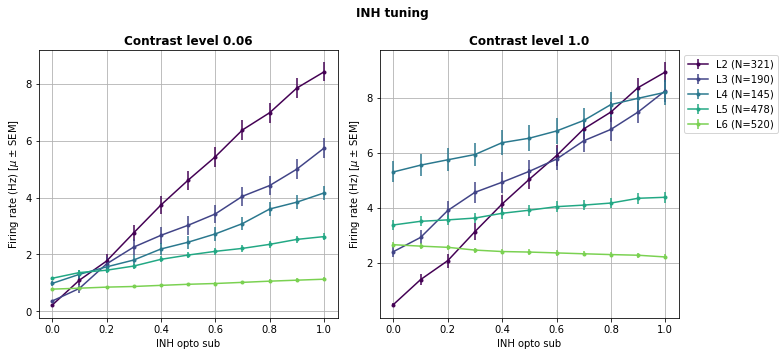

In [7]:
# Plot INH tuning
plot_tuning(psth_data_inh, tuning_curves_inh, tuning_property, circuit, gids_inh, contrast_list=[0.06, 1.0], is_norm=False, y_lim=None, save_path=save_path)

In [8]:
# Compute EXC tuning
tuning_curves_exc, baselines_exc, gids_exc = compute_tuning(psth_data_exc, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7 8 9 10

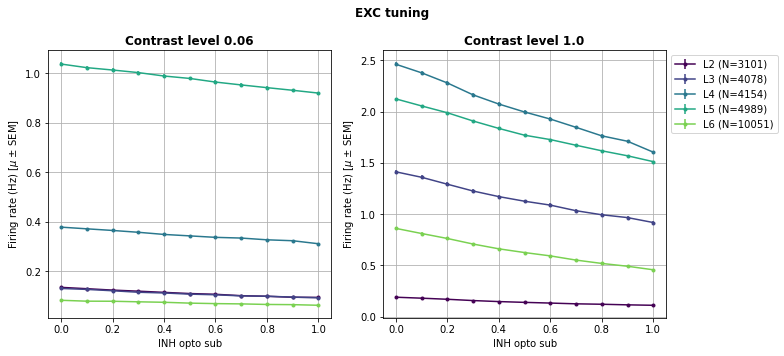

In [9]:
# Plot EXC tuning
plot_tuning(psth_data_exc, tuning_curves_exc, tuning_property, circuit, gids_exc, contrast_list=[0.06, 1.0], is_norm=False, y_lim=None, save_path=save_path)

In [10]:
# Compute normalized INH tuning
norm_tuning_curves_inh, norm_baselines_inh, gids_inh = compute_tuning(psth_data_inh, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7 8 9 10

In [11]:
# Compute normalized EXC tuning
norm_tuning_curves_exc, norm_baselines_exc, gids_exc = compute_tuning(psth_data_exc, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7 8 9 10

In [12]:
def plot_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuit, contrasts, tuning_values, merged_layers=None, tuning_property=None, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim"""
    num_sims = len(tuning_values)
    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)
    
    layers = list(np.unique(circuit.cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    plt.figure(figsize=(12, 3))
    for lidx, layer in enumerate(layers):
        plt.subplot(1, len(layers), lidx + 1)
        gids_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]

        depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
        gid_idx = np.where(np.isin(gids, gids_sel))[0]
        gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
        assert len(gid_idx) > 0, 'ERROR: No GIDs selected!'
        for sidx in range(num_sims):
            if tuning_values[sidx] == 0.0:
                plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=depol_colors[sidx, :], label=f'{tuning_values[sidx]}')
            else:
                plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=depol_colors[sidx, :], label=f'{tuning_values[sidx]}')
        plt.xlim((-0.25, num_patterns + 0.25))
        plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
        plt.xlabel('Contrast')
        plt.ylabel('Norm. rate')
        plt.grid()
        plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer} (N={len(gid_idx)})')
    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], title=tuning_property)
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

In [13]:
def plot_split_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuits, opto_props, contrasts, tuning_values, merged_layers=None, tuning_property=None, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim,
       splitted into cells that are (not) targeted by opto stimulus"""
    num_sims = len(tuning_values)
    assert len(circuits) == num_sims, f'ERROR: List of {num_sims} circuits required!'
    assert len(opto_props) == num_sims, f'ERROR: List of {num_sims} opto property dicts required!'

    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuits[0].cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    level_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    tgt_ls = ['--', '-'] # Line styles for non-targeted/targeted cells

    plt.figure(figsize=(12, 3))
    print(f'Plotting ({num_sims} steps)...', end='')
    for sidx in range(num_sims):
        print(f'{sidx + 1}', end=' ')
        # Select targeted/non-targeted GIDs
        tgt_gids = []
        for tgt in opto_props[sidx]['inject_target_names']:
            tgt_gids.append(circuits[sidx].cells.ids(tgt))
        if len(tgt_gids) > 0:
            tgt_gids = np.unique(np.hstack(tgt_gids))

        for lidx, layer in enumerate(layers):
            plt.subplot(1, len(layers), lidx + 1)
            gids_lay_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]
            gids_sel_tgt = np.intersect1d(gids_lay_sel, tgt_gids)
            gids_sel_nontgt = np.setdiff1d(gids_lay_sel, gids_sel_tgt)

            for sel_idx, gids_sel in enumerate([gids_sel_nontgt, gids_sel_tgt]):
                gid_idx = np.where(np.isin(gids, gids_sel))[0]
                gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
                if len(gid_idx) == 0:
                    continue

                if sel_idx == 0:
                    lbl = f'{tuning_values[sidx]} (non-tgt)'
                else:
                    lbl = f'{tuning_values[sidx]} (tgt)'
                if tuning_values[sidx] == 0.0:
                    plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
                else:
                    plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
            plt.xlim((-0.25, num_patterns + 0.25))
            plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
            plt.xlabel('Contrast')
            plt.ylabel('Norm. rate')
            plt.grid()
            plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer}')

    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], ncol=2, title=tuning_property)
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'split_mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

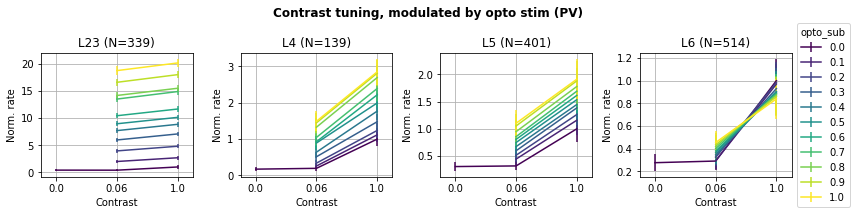

In [14]:
# Plot mean INH contrast tuning per layer, modulated by opto stim
tuning_values = [psth_data_inh[sidx]['opto_cfg']['cfg'][tuning_property] for sidx in range(len(psth_data_inh))]
contrasts = psth_data_inh[0]['stim_cfg']['cfg']['contrast_levels']

plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuit, contrasts, tuning_values, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=inh_label)

Plotting (11 steps)...1 2 3 4 5 6 7 8 9 10 11 

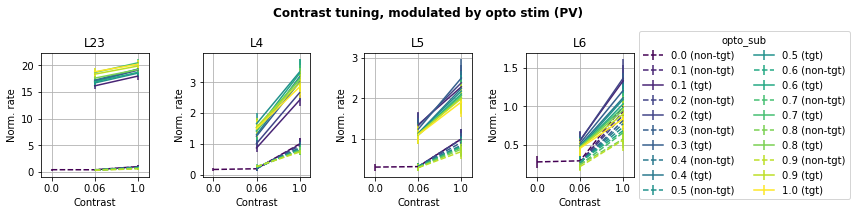

In [15]:
circuits = [Simulation(sims.iloc[sidx]).circuit for sidx in range(sims.shape[0])]
opto_props = [psth_data_inh[sidx]['opto_cfg']['props'] for sidx in range(len(psth_data_inh))]
plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuits, opto_props, contrasts, tuning_values, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=inh_label)

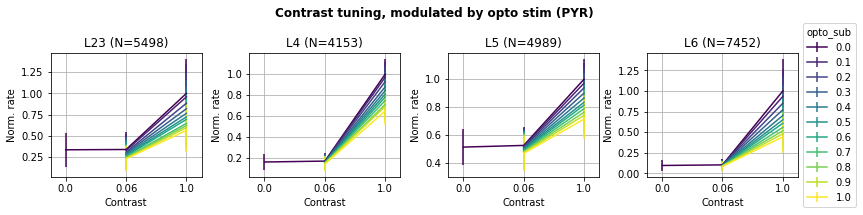

In [16]:
# Plot mean EXC contrast tuning per layer, modulated by opto stim
tuning_values = [psth_data_exc[sidx]['opto_cfg']['cfg'][tuning_property] for sidx in range(len(psth_data_exc))]
contrasts = psth_data_exc[0]['stim_cfg']['cfg']['contrast_levels']

plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuit, contrasts, tuning_values, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=exc_label)

Plotting (11 steps)...1 2 3 4 5 6 7 8 9 10 11 

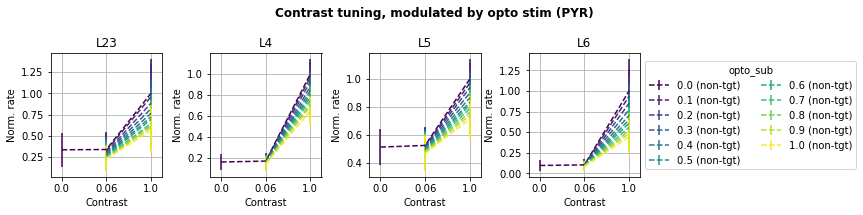

In [17]:
circuits = [Simulation(sims.iloc[sidx]).circuit for sidx in range(sims.shape[0])]
opto_props = [psth_data_exc[sidx]['opto_cfg']['props'] for sidx in range(len(psth_data_exc))]
plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuits, opto_props, contrasts, tuning_values, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=exc_label)